In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [109]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 435)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,thick_12.0,thick_15.0,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0,0,0,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0,0,0,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0,0,0,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0,0,0,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0,0,0,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [110]:
#Volumic cost calculation

dataset['VOL_COST_CONVHULL'] = dataset['VAMAT'] / (dataset['convex_hull_area'] * dataset['thickness'])
dataset['VOL_COST_RECTANGLE'] = dataset['VAMAT'] / (dataset['minimum_rectangle_area'] * dataset['thickness'])
dataset['VOL_COST_MPATTERN'] = dataset['VAMAT'] / (dataset['no_hole_area'] * dataset['thickness'])
dataset['VOL_COST_TOTAREA'] = dataset['VAMAT'] / (dataset['total_area'] * dataset['thickness'])

In [111]:
dataset.columns.values

array(['cut_length', 'num_closed_patterns', 'num_open_patterns',
       'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1',
       'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',
       'thickness', 'radius_approx', 'radius_count', 'direction_count',
       'bend_count', 'benddxf_bend_radius_00', 'benddxf_bend_angle_00',
       'benddxf_bend_direction_00', 'benddxf_deformation_length_00',
       'benddxf_merged_bend_00', 'benddxf_punch_length_00',
       'benddxf_bend_radius_01', 'benddxf_bend_angle_01',
       'benddxf_bend_direction_01', 'benddxf_deformation_length_01',
       'benddxf_merged_bend_01', 'benddxf_punch_length_01',
       'benddxf_bend_radius_02', 'benddxf_bend_angle_02',
       'benddxf_bend_direction_02', 'benddxf_deformation_length_02',
       'benddxf_merged_bend_02', 'benddxf_punch_length_02',
       'benddxf_bend_radius_03', 'benddxf_bend_angle_03',
       'benddxf_bend_direction_03', 'benddxf_deformation_length_03',
       'benddxf_mer

In [112]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
Done !


In [113]:
#Cleaning of the remaining Nan
#dataset = dataset.fillna(0)
dataset = dataset.dropna()
dataset.shape

(5105, 436)

# cleaning to have at least min occurences

In [114]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 436)

## Outlier tracking

In [115]:
toplimit = .20 #We drop the top x%
botlimit = .05 #we drop the bottom y%

In [116]:
criterias = ['VOL_COST_CONVHULL',
             'VOL_COST_RECTANGLE',
             #'VOL_COST_MPATTERN',
             #'VOL_COST_TOTAREA'
            ]

In [117]:
quant = dataset[criterias].quantile([botlimit,1-toplimit])
quant

,VOL_COST_CONVHULL,VOL_COST_RECTANGLE
0.05,0.000006,0.000005
0.80,0.000011,0.000008


In [118]:
for column in quant.columns.values:
    lowerlimit = quant[column].iloc[0]
    upperlimit = quant[column].iloc[1]
    
    #Upper limit triming
    dataset = dataset[dataset[column] < upperlimit]
    
    #Lower limit trimming
    dataset = dataset[dataset[column] > lowerlimit]
dataset.shape

(3424, 436)

# Dataset re-ordering and Splitting

In [181]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

#Bend as a float
limitedset.append('thickness')

## Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

#Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

#Bends in groups
limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

#bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

print(len(limitedset))
limitedset

153


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bend_gr_0_bend_radius_count',
 'bend_gr_0_bend_radius_countdif',
 'bend_gr_0_bend_radius_mean',
 'bend_gr_0_bend_radius_std',
 'bend_gr_0_bend_radius_max',
 'bend_gr_0_bend_radius_min',
 'bend_gr_0_bend_angle_countdif',
 'bend_gr_0_bend_angle_mean',
 'bend_gr_0_bend_angle_std',
 'bend_gr_0_bend_angle_max',
 'bend_gr_0_bend_angle_min',
 'bend_gr_0_bend_direction_countdif',
 'bend_gr_0_bend_direction_mean',
 'bend_gr_0_bend_direction_std',
 'bend_gr_0_bend_direction_max',
 'bend_gr_0_bend_direction_min',
 'bend_gr_0_deformation_length_mean',
 'bend_gr_0_deformation_length_std',
 'bend_gr_0_deformation_length_max',
 'bend_gr_0_deformation_length_min',
 'bend_gr_0_merged_bend_mean',
 'bend_gr_0_merged_bend_std',
 'bend_gr_0_merged_

In [183]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

In [184]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

# Target definition

In [185]:
target = 'VALAJOUT'
assert target in y.columns.values, 'The target must be in y dataset'

,VALAJOUT
count,3424.000000
mean,2.925015
std,2.327616
min,0.140000
25%,1.510000
50%,2.390000
75%,3.590000
max,42.590000


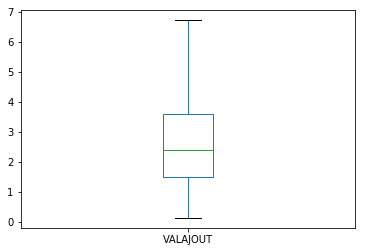

In [186]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Blocs creation

In [187]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [188]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [189]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [190]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        learning_rate=0.05,
                        n_estimators=400,
                        max_depth=500,
                        #lambda_l1=0.1,
                        min_child_samples=10,
                        random_state=0,
                       )

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [192]:
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)

In [193]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=500, min_child_samples=10,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [194]:
param_grid = {
    #'gbm__learning_rate': [0.05, 0.1, ],
    #'gbm__n_estimators': [300, 400, 500],
    'gbm__min_child_samples' : [10,5,15],
    #'gbm__lambda_l1': np.logspace(-3,3,4),
    #'gbm__lambda_l2': np.logspace(-3,3,4),
    #'gbm__max_bin':[200, 150],
    #'gbm__num_leaves':[20,25],
    #'gbm__max_depth':[None, 500,750],
    #'gbm__min_split_gain':[0,.1]
    }

#MSE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#MAPE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [195]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gbm__min_child_samples=10 .......................................
[CV] gbm__min_child_samples=10 .......................................
[CV] gbm__min_child_samples=10 .......................................
[CV] ........................ gbm__min_child_samples=10, total=   4.3s
[CV] gbm__min_child_samples=5 ........................................
[CV] ........................ gbm__min_child_samples=10, total=   5.3s
[CV] gbm__min_child_samples=5 ........................................
[CV] ........................ gbm__min_child_samples=10, total=   5.4s
[CV] gbm__min_child_samples=5 ........................................
[CV] ......................... gbm__min_child_samples=5, total=   4.0s
[CV] gbm__min_child_samples=15 .......................................
[CV] ......................... gbm__min_child_samples=5, total=   6.4s
[CV] gbm__min_child_samples=15 .......................................
[CV] .............

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   16.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=500, min_child_samples=10,
       min_child_weight=0.001, min_sp...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__min_child_samples': [10, 5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
       verbose=2)

In [196]:
target

'VALAJOUT'

In [197]:
gridgbm.best_params_

{'gbm__min_child_samples': 5}

In [198]:
gridgbm.best_score_

-24.704729479245543

In [199]:
mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))

21.812132356481413

In [200]:
mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))

1.5502727614984875

In [201]:
mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))

0.08632965272196769

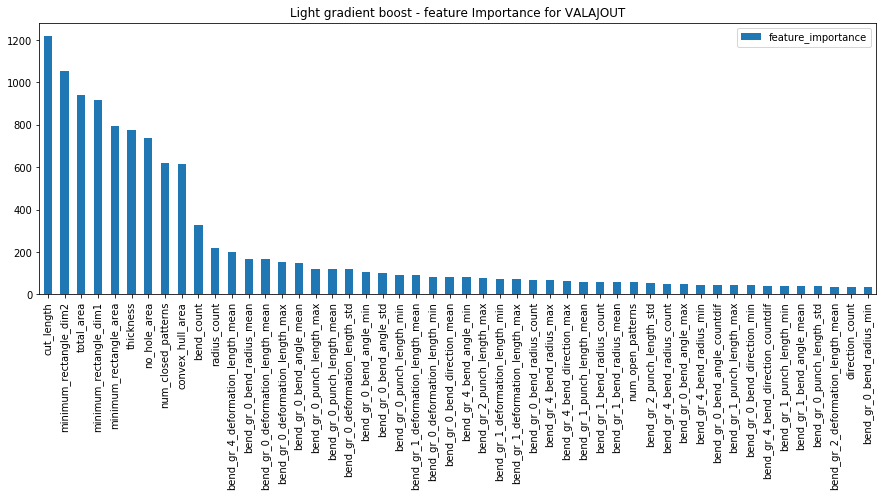

In [202]:
featimp = list(gridgbm.best_estimator_.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# Solution comparison

In [203]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])

In [204]:
resultset = pd.DataFrame({'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,target
COART,,
L8422140,1.727368,1.37
L3081550,0.988278,0.74
L7068080,0.883131,0.95
L7064090,2.644295,2.87
L7065500,1.645279,1.51


In [205]:
mean_squared_error(resultset['target'], resultset['pred_lgbm'])

1.5502727614984875

In [206]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])

21.812132356481413

In [207]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset.head()

,pred_lgbm,target,MSE_lgbm
COART,,,
L8422140,1.727368,1.37,0.127712
L3081550,0.988278,0.74,0.061642
L7068080,0.883131,0.95,0.004471
L7064090,2.644295,2.87,0.050943
L7065500,1.645279,1.51,0.018301


In [208]:
resultset['MSE_lgbm'].mean()

1.5502727614984875

In [209]:
#
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,target,MSE_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,...,thick_15.0,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,VOL_COST_TOTAREA
0,L8422140,1.727368,1.37,0.127712,780.102295,3,0,14372.121094,25537.626953,185.988876,...,0,0,1.40,1.37,2.77,0.000009,0.000007,0.000012,0,0.000012
1,L3081550,0.988278,0.74,0.061642,859.310730,9,0,9795.242188,15600.000000,130.000000,...,0,0,0.49,0.74,1.23,0.000008,0.000006,0.000009,0,0.000010
2,L7068080,0.883131,0.95,0.004471,759.674438,3,0,12064.058594,23463.193359,236.433395,...,0,0,0.44,0.95,1.39,0.000008,0.000006,0.000012,0,0.000012
3,L7064090,2.644295,2.87,0.050943,1132.625366,6,0,27597.535156,44497.050781,257.831299,...,0,0,1.62,2.87,4.49,0.000008,0.000006,0.000009,1-2,0.000010
4,L7065500,1.645279,1.51,0.018301,1098.674072,4,0,32501.710938,55440.000000,240.000000,...,0,0,2.06,1.51,3.57,0.000008,0.000006,0.000010,0,0.000011


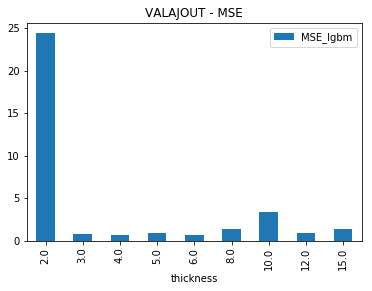

,MSE_lgbm
thickness,
2.0,24.360150
3.0,0.744155
4.0,0.673117
5.0,0.889126
6.0,0.622200
8.0,1.321337
10.0,3.320277
12.0,0.850693
15.0,1.343943


In [210]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
df

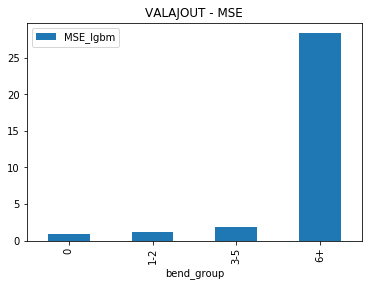

,MSE_lgbm
bend_group,
0,0.853145
1-2,1.207906
3-5,1.842964
6+,28.354020


In [211]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
df

In [212]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['percent_error'] = ((comparisonset['target'] / comparisonset['pred_lgbm'])-1)*100
comparisonset[['target', 'pred_lgbm', 'MAPE_error']].head()

,target,pred_lgbm,MAPE_error
0,1.37,1.727368,26.085233
1,0.74,0.988278,33.551140
2,0.95,0.883131,7.038814
3,2.87,2.644295,7.864300
4,1.51,1.645279,8.958898


In [213]:
#MAPE
comparisonset['MAPE_error'].mean()

21.81213235648143

In [214]:
#If bends use this line
df = comparisonset[['MSE_lgbm', 'MAPE_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
#df = comparisonset[['MSE_lgbm', 'MAPE_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_lgbm': ['mean', 'max'], 'MAPE_error': ['mean', 'max'],'COART':['count'] })

MSE_lgbm             MAPE_error             COART
                           mean         max       mean         max count
thickness bend_group                                                    
2.0       1-2          2.888493   10.047740  33.599477  108.056944     6
          3-5          1.375622    4.937271  20.983384   39.045233     7
          6+          96.790560  261.969821  97.850272  251.327357     4
3.0       0            0.568591    5.366091  36.962433  145.626423    21
          1-2          0.412235    5.469012  19.226907   97.725930    39
          3-5          1.081589    6.726616  20.373972  133.190829    25
          6+           2.793114    7.757707  15.424382   24.010914     4
4.0       0            0.154383    0.874805  49.362132  161.000090    18
          1-2          0.168818    1.426254  21.299232  216.179907    91
          3-5          2.846145   22.971920  18.514192   71.851869    22
          6+           4.384018    8.759466  23.647708   45.603074     2
5.0       0            0.734728    8.546745  43.730373  215.559865    41
          1-2          0.789181   40.354555  19.108171  192.674404    66
          3-5          0.782217    8.468719  10.945318   37.511032    32
          6+           9.062984   16.733396  68.715231  120.668063     2
6.0       0            0.370212    6.512446  23.138723  116.375049    88
          1-2          0.531200   10.004509  22.502150  244.983978   118
          3-5          2.130813   15.213208  25.709310   86.270146    23
          6+           0.027202    0.071314   1.612339    3.248746     3
8.0       0            1.328511   95.769191  16.968591   60.865183    95
          1-2          1.367727   92.392659  14.587283   67.417191    96
          3-5          0.979003   11.845578   6.842447   17.624888    15
10.0      0            0.807596   22.128966  18.549763   94.134450    59
          1-2          5.654432  257.493284  12.741301   81.289753    51
          3-5          7.492592   21.138130  20.062191   43.129665     7
12.0      0            1.038951   18.125073  33.179730  162.916582    44
          1-2          0.311382    3.344179  13.765549   87.006080    19
          3-5          2.814216    2.814216  69.608408   69.608408     1
15.0      0            1.440015   13.019079  24.246393  107.726164    26
          1-2          0.511316    1.063836  17.990461   26.470730     3

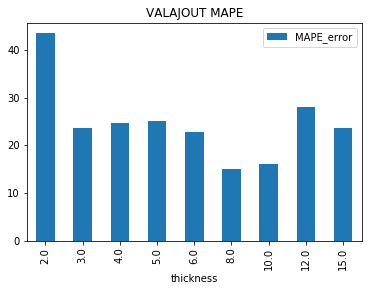

,MAPE_error
thickness,
2.0,43.522449
3.0,23.563003
4.0,24.671850
5.0,25.118902
6.0,22.791433
8.0,15.121515
10.0,16.108357
12.0,27.985343
15.0,23.599228


In [215]:
df = comparisonset[['MAPE_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
df

In [216]:
df = comparisonset[['COART', 'thickness']]
df.groupby('thickness').count()

,COART
thickness,
2.0,17
3.0,89
4.0,133
5.0,141
6.0,232
8.0,206
10.0,117
12.0,64
15.0,29


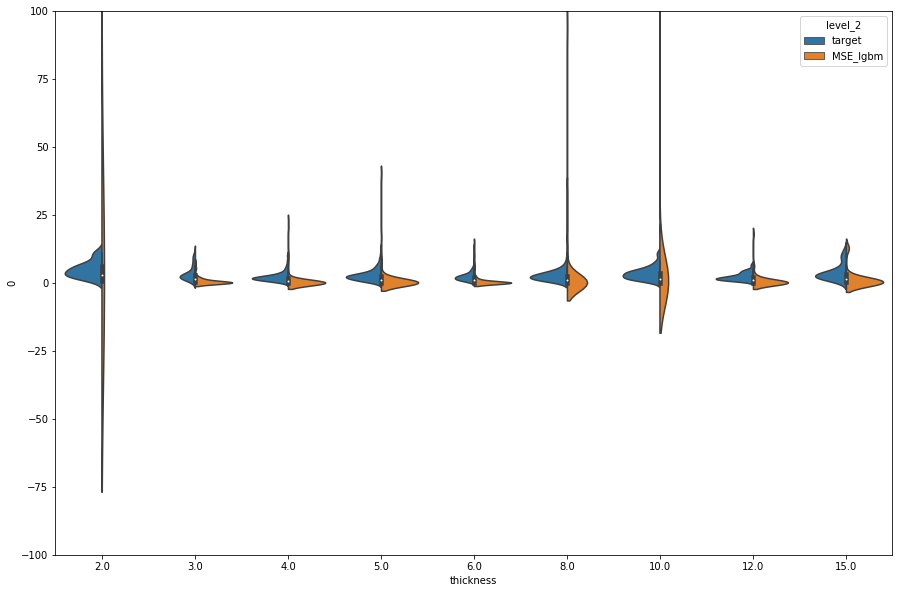

In [217]:
df=comparisonset[['target', 'MSE_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)

plt.show()

In [224]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    261.969821
           L7070650    122.176340
           L7062540     10.047740
           L7067200      7.008701
           L8045480      4.937271
3.0        L3103511      7.757707
           L6703390      6.726616
           L7069760      5.469012
           L6006341      5.366091
           L8416800      3.003283
4.0        L6703401     22.971920
           L6703411     20.420860
           L6704071     10.806772
           L8052720      8.759466
           L6704081      2.794090
5.0        L8415700     40.354555
           L7073520     16.733396
           L7065341      8.546745
           L5608911      8.468719
           L8834480      5.803434
6.0        L5704350     15.213208
           L7057910     10.004509
           L7069750      7.619246
           L6012941      6.811511
           L8403330      6.512446
8.0        L2607690     95.769191
           L2607680     92.392659
           L8038170     12.195747
           L2609180     11.8

In [222]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 10]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
df = df[df['minimum_rectangle_area'] < 40000]
df = df[df['minimum_rectangle_area'] > 35000]

#bend_count filter
df = df[df['bend_count'] == 2]

#df[df['COART']=='L3128890'].T
df.T

,281,288,594,609
COART,L8834330,L8044260,L7061231,L1801770
pred_lgbm,3.6934,3.86176,3.21346,2.03732
target,19.74,3.46,3.25,2.06
MSE_lgbm,257.493,0.161414,0.00133501,0.000514485
cut_length,1035.91,1228.64,1010.47,1284.95
num_closed_patterns,4,6,4,1
num_open_patterns,0,0,0,0
total_area,28405.2,22981.7,22969.5,39064.2
minimum_rectangle_area,38550.2,35344,37985.6,39064.2
minimum_rectangle_dim1,235.84,363.938,271.328,574.473


In [220]:
dataset.loc[['L8834330']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L8834330
cut_length,1035.91
num_closed_patterns,4
num_open_patterns,0
total_area,28405.2
minimum_rectangle_area,38550.2
minimum_rectangle_dim1,235.84
minimum_rectangle_dim2,163.459
convex_hull_area,32451
no_hole_area,30790.5
thickness,10
